# Credit Card Transaction Fraud Detection

In [1]:
# Preprocessing
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.inspection import permutation_importance

# Oversampling and Undersampling
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

# Model
import shap
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

# Figures
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import ConfusionMatrixDisplay

# For reproducability
import random
RANDOM_STATE = 1
random.seed(RANDOM_STATE)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Loading the data.

In [2]:
data = pd.read_csv(r"./fraudTrain.csv")

data.drop(data.columns[0], axis=1, inplace=True)

## Imbalanced Data

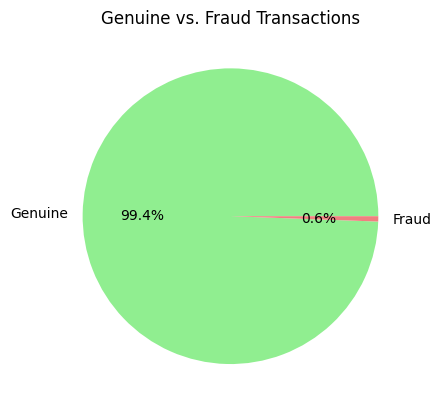

In [3]:
labels = ["Genuine", "Fraud"]

is_fraud_train = data["is_fraud"].value_counts()

plt.pie(is_fraud_train,labels=labels, colors=["lightgreen", "lightcoral"], autopct='%1.1f%%')
plt.title("Genuine vs. Fraud Transactions")
plt.show()

Since 99.4% of the data are genuine transactions, if we do a blind guess of genuine transactions, we will have an accuracy of 99.4%.

## Exploratory Data Analysis

Renaming the columns to be more intuitive and converted the times to be datetimes.

In [4]:
data.rename(columns={"cc_num": "credit_card",
                     "trans_date_trans_time": "trans_time",
                     "trans_num": "trans_id"},
                inplace=True)

# Turning the transaction time to be numerical and based on time only.
data["trans_time"] = pd.to_datetime(data["trans_time"])
data["dob"] = pd.to_datetime(data["dob"])

# Changing to time of day.
data["time"] = pd.to_datetime(data["unix_time"], unit="s")
data["time"] = data["time"].dt.hour

data.head(5)

,trans_time,credit_card,merchant,category,amt,first,last,gender,street,city,...,long,city_pop,job,dob,trans_id,unix_time,merch_lat,merch_long,is_fraud,time
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0


Checking for missing data.

In [43]:
data.isnull().sum()

trans_time     0
credit_card    0
merchant       0
category       0
amt            0
first          0
last           0
gender         0
street         0
city           0
state          0
zip            0
lat            0
long           0
city_pop       0
job            0
dob            0
trans_id       0
unix_time      0
merch_lat      0
merch_long     0
is_fraud       0
time           0
dtype: int64

Checking elements within features.

In [44]:
for col in data:
    unique_vals = np.unique(data[col])
    n_unique = len(unique_vals)
    if n_unique < 24:
        print(f"The number of unique values for features {col}: {n_unique} ---> {unique_vals}")
    else:
        print(f"The number of unique values for features {col}: {n_unique}")

The number of unique values for features trans_time: 1274791
The number of unique values for features credit_card: 983
The number of unique values for features merchant: 693
The number of unique values for features category: 14 ---> ['entertainment' 'food_dining' 'gas_transport' 'grocery_net' 'grocery_pos'
 'health_fitness' 'home' 'kids_pets' 'misc_net' 'misc_pos' 'personal_care'
 'shopping_net' 'shopping_pos' 'travel']
The number of unique values for features amt: 52928
The number of unique values for features first: 352
The number of unique values for features last: 481
The number of unique values for features gender: 2 ---> ['F' 'M']
The number of unique values for features street: 983
The number of unique values for features city: 894
The number of unique values for features state: 51
The number of unique values for features zip: 970
The number of unique values for features lat: 968
The number of unique values for features long: 969
The number of unique values for features city_pop

Visualizing transaction amounts over time.

In [45]:
grouped = data.groupby(by=[pd.Grouper(key="trans_time", freq="1M"), 'category'])
grouped = grouped.aggregate({"amt":'sum',"trans_id":"count"}).reset_index()

fig = px.area(grouped, x='trans_time', y='amt', 
              color='category', title="Transaction Amounts Over Time",
              labels={'trans_time': 'Transaction Time', 'amt': 'Amount'})

fig.update_layout(height=600, width=900, legend=dict(title='Categories'))

fig.show()

Visualizing transactions by category.

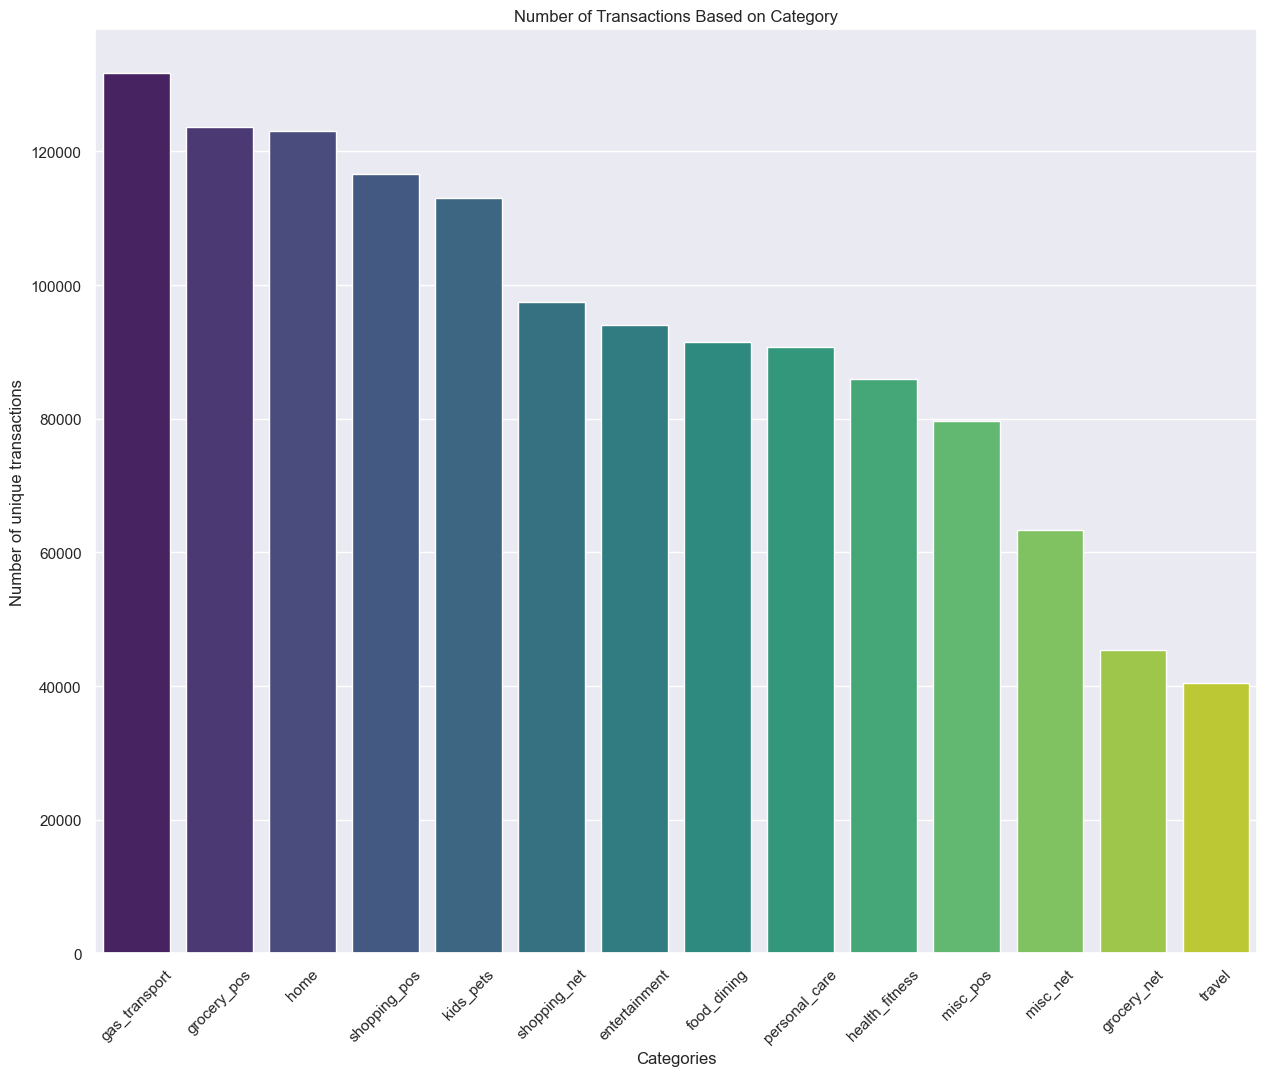

<Figure size 1500x1200 with 0 Axes>

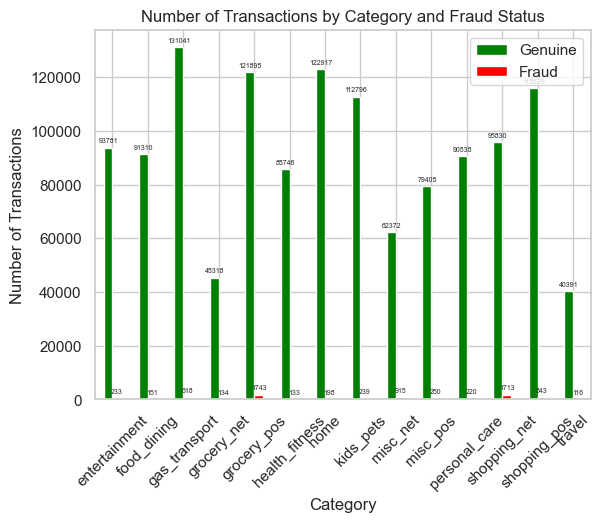

In [46]:
grouped = data.groupby("trans_id")["category"].aggregate("max").reset_index()
grouped = grouped.category.value_counts()

# Plotting
sns.set_style('dark')
colors = sns.color_palette("viridis", n_colors=len(grouped))
f, ax = plt.subplots(figsize=(15, 12))

sns.barplot(x=grouped.index, y=grouped.values, hue=grouped.index, ax=ax, palette=colors, legend=False)
ax.grid(True, axis='y')

plt.xticks(rotation=45)
plt.ylabel('Number of unique transactions')
plt.xlabel('Categories')
plt.title('Number of Transactions Based on Category')
plt.show()

# Split into fraud or not
grouped = data[["trans_id", "category", "is_fraud"]].groupby(['category', 'is_fraud']).size().unstack()

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(15, 12))
ax = grouped.plot(kind='bar', stacked=False, color=['green', 'red'])

# Adding the numbers to bars
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=5)

plt.xticks(rotation=45)
plt.xlabel('Category')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions by Category and Fraud Status')
plt.legend(['Genuine', 'Fraud'])
plt.show()

Visualizing transactions based on time of day.

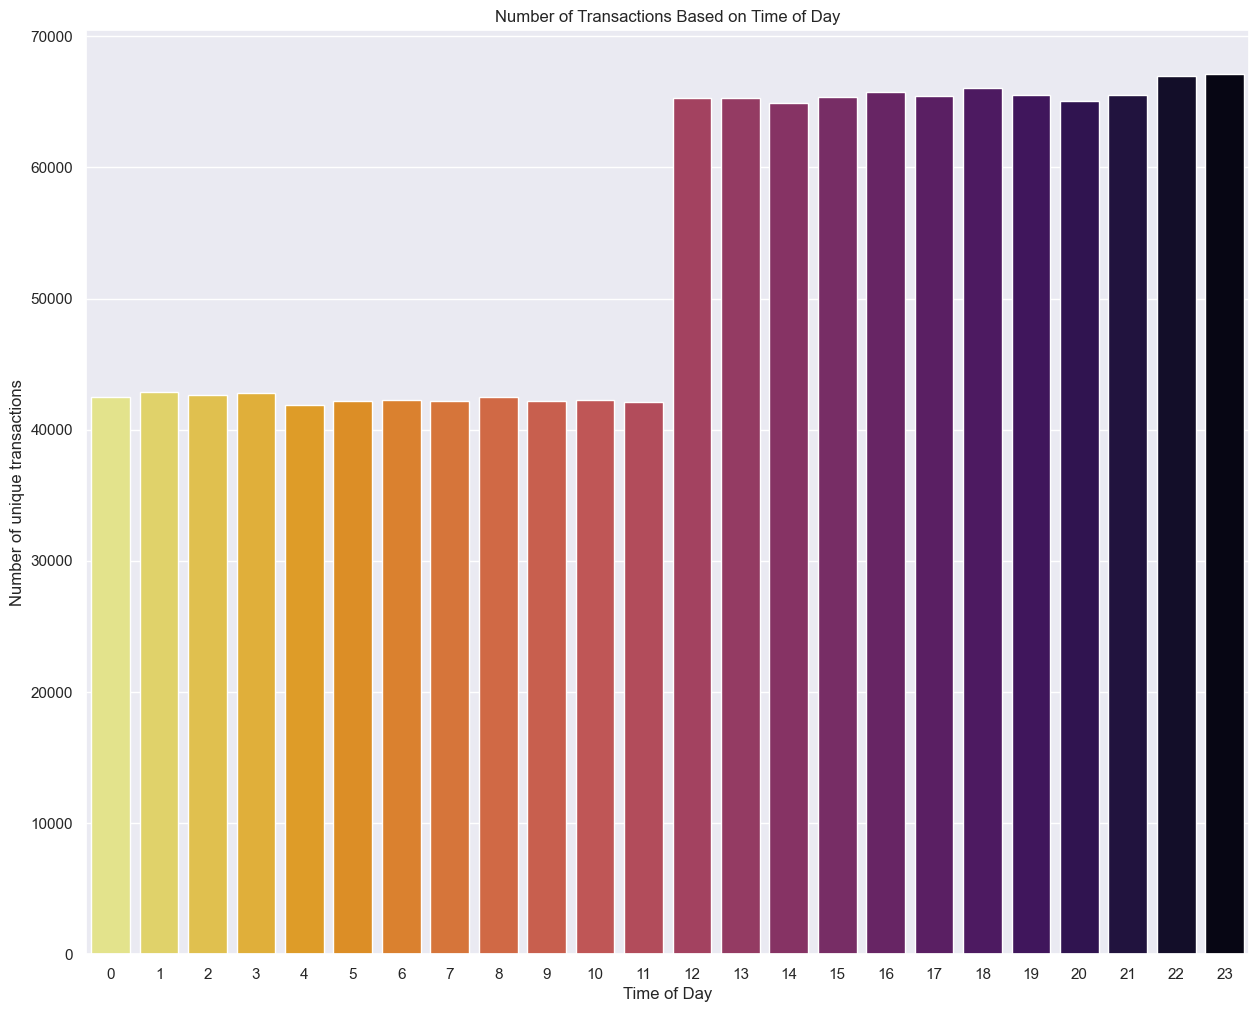

<Figure size 1500x1200 with 0 Axes>

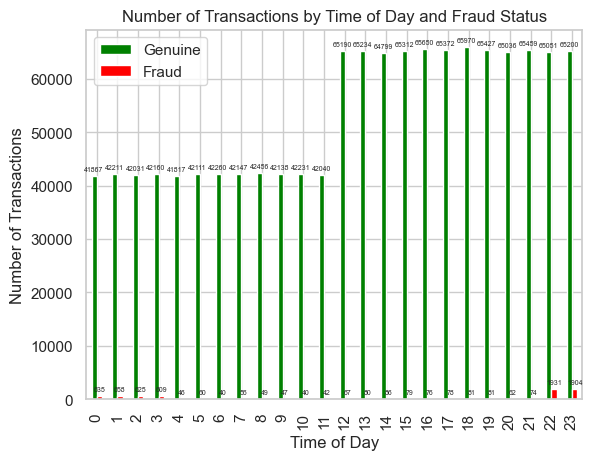

In [47]:
grouped = data.groupby("trans_id")["time"].aggregate("max").reset_index()
grouped = grouped.time.value_counts()

# Plotting
sns.set_style('dark')
colors = sns.color_palette("inferno_r", n_colors=len(grouped))
f, ax = plt.subplots(figsize=(15, 12))

sns.barplot(x=grouped.index, y=grouped.values, hue=grouped.index, ax=ax, palette=colors, legend=False)
ax.grid(True, axis='y')

plt.ylabel('Number of unique transactions')
plt.xlabel('Time of Day')
plt.title('Number of Transactions Based on Time of Day')
plt.show()

# Split into fraud or not
grouped = data[["trans_id", "time", "is_fraud"]].groupby(['time', 'is_fraud']).size().unstack()

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(15, 12))
ax = grouped.plot(kind='bar', stacked=False, color=['green', 'red'])

# Adding the numbers to bars
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=5)

plt.xlabel('Time of Day')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions by Time of Day and Fraud Status')
plt.legend(['Genuine', 'Fraud'])
plt.show()

## Preprocessing Data
We convert the date of birth to age and normalize the amount.

In [5]:
# Normalizing the amount via log(1 + amt)
data["log1p(amt)"] = np.log1p(data["amt"])

# Change dob to age to prevent data leakage, and removal of private information
data["age"] = data["trans_time"].dt.year - data["dob"].dt.year


Removing any unecessary features and taking the 4 most recent months as testing data to prevent data leakage.

In [6]:
# Removed trans_id. Replaced unix_time and trans_date_trans_time with time. Replaced dob with age.
# Also removed private information such as name, dob, address.
features = ['credit_card', 'merchant', 'category', 'log1p(amt)', 'gender', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'age', 'merch_lat', 'merch_long', 'time']
categorical_features = ['credit_card', 'merchant', 'category', 'gender', 'state', 'zip', 'job', 'age']
target = "is_fraud"

# Separates all the data within the most recent MONTH_DIFF months to prevent data leakage
MONTH_DIFF = 4 # Sets the month difference to split by for training
MONTH_DIFF_TEST = MONTH_DIFF/2 # Sets the month difference to split by for validation
most_recent_transaction = data["trans_time"].max()
data["month_difference"] = abs(data["trans_time"] - most_recent_transaction) / np.timedelta64(30, "D")

data_train = data[data["month_difference"] > MONTH_DIFF]
data_val = data[(data["month_difference"] <= MONTH_DIFF) 
                & (data["month_difference"] > MONTH_DIFF_TEST)]
data_test = data[data["month_difference"]  <= MONTH_DIFF_TEST]

Ensuring the data is the same across the training, testing and validation.

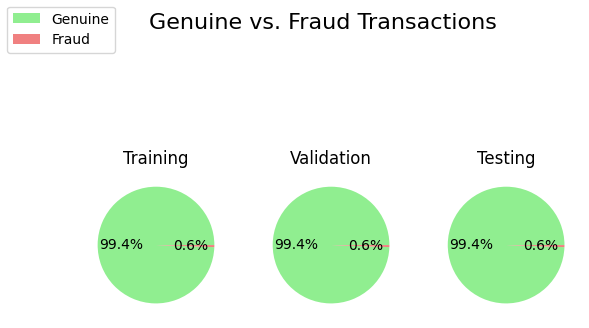

In [7]:
labels = ["Genuine", "Fraud"]

is_fraud_train = data_train["is_fraud"].value_counts()
is_fraud_val = data_val["is_fraud"].value_counts()
is_fraud_test = data_test["is_fraud"].value_counts()

fig, axs = plt.subplots(1, 3)
                        
axs[0].pie(is_fraud_train, labels=None, colors=["lightgreen", "lightcoral"], autopct='%1.1f%%')
axs[0].set_title("Training")

axs[1].pie(is_fraud_val, labels=None, colors=["lightgreen", "lightcoral"], autopct='%1.1f%%')
axs[1].set_title("Validation")

axs[2].pie(is_fraud_train, labels=None, colors=["lightgreen", "lightcoral"], autopct='%1.1f%%')
axs[2].set_title("Testing")

plt.suptitle('Genuine vs. Fraud Transactions', fontsize=16)
fig.legend(labels, loc='upper left')

plt.show()

Splitting our data into features and outputs, and encoding the data

In [8]:
# Split the data into train, test and validation
X_train = data_train[features]
Y_train = data_train[target]

X_val = data_val[features]
Y_val = data_val[target]

X_test = data_test[features]
Y_test = data_test[target]

# Using ordinal encodings to encode categorical features for data.
ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1, dtype=np.float64)

X_train.loc[:, categorical_features] = ord_enc.fit_transform(X_train[categorical_features])
X_val.loc[:, categorical_features] = ord_enc.transform(X_val[categorical_features])
X_test.loc[:, categorical_features] = ord_enc.transform(X_test[categorical_features])

X_train = X_train.astype("float64")
X_val = X_val.astype("float64")
X_test = X_test.astype("float64")

## Feature Importance

To determine which features to select, fit a model to the data.

In [14]:
model_rf = RandomForestClassifier(random_state=RANDOM_STATE)
model_rf.fit(X_train, Y_train)

RandomForestClassifier(random_state=1)

Using feature permutation, plot the feature importance to determine the most important features.

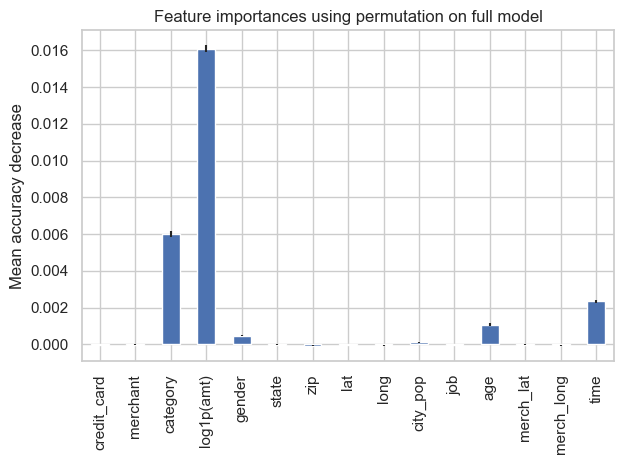

In [15]:
perm_res = permutation_importance(
    model_rf, X_val, Y_val, n_repeats=10, random_state=RANDOM_STATE, n_jobs=4
)

perm_importances = pd.Series(perm_res.importances_mean, index=features)

perm_fig, perm_ax = plt.subplots()
perm_importances.plot.bar(yerr=perm_res.importances_std, ax=perm_ax)
perm_ax.set_title("Feature importances using permutation on full model")
perm_ax.set_ylabel("Mean accuracy decrease")
perm_fig.tight_layout()
plt.show()

The features `["category", "log1p(amt)", "gender", "city_pop", "age", "time"]` were found to be the most important.

In [9]:
selected_features = ["category", "log1p(amt)", "gender", "city_pop", "age", "time"]

X_train, X_val, X_test = X_train[selected_features], X_val[selected_features], X_test[selected_features]

## Baseline Performance
We take a look at the baseline performance of Random Forest

In [17]:
model_rf.fit(X_train, Y_train)

Y_pred_model_rf = model_rf.predict(X_val)

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    131770
           1       0.95      0.82      0.88       745

    accuracy                           1.00    132515
   macro avg       0.97      0.91      0.94    132515
weighted avg       1.00      1.00      1.00    132515



Metrics train:
	Accuracy score: 1.0000
Metrics test:
	Accuracy score: 0.9987


Confusion Matrix:


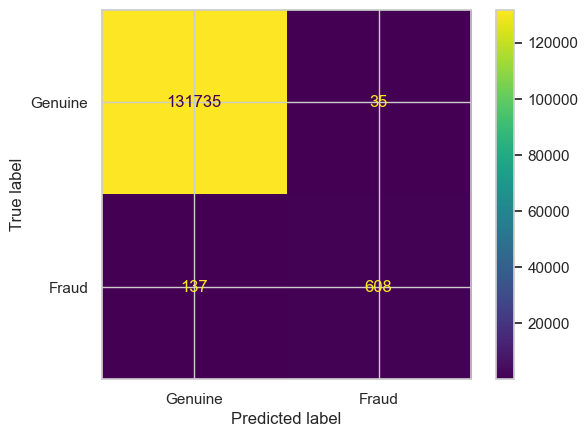

In [18]:
print(f"Classification Report: \n{classification_report(Y_val, Y_pred_model_rf)}\n\n")

print(
    f"Metrics train:\n\tAccuracy score: {accuracy_score(model_rf.predict(X_train),Y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(model_rf.predict(X_val),Y_val):.4f}\n\n")

print("Confusion Matrix:")
cm_display_model = ConfusionMatrixDisplay(confusion_matrix(Y_val, Y_pred_model_rf), display_labels=["Genuine", "Fraud"])
cm_display_model.plot()

## SMOTE + Tomek Links
Because the data is imbalanced, we combine SMOTE and Tomek Links to resample the data.

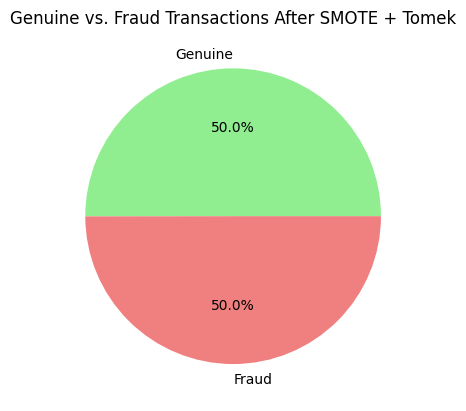

In [10]:
tomek = TomekLinks(sampling_strategy="majority")
smotetomek = SMOTETomek(tomek=tomek, random_state=RANDOM_STATE)

X_train_smotetomek, Y_train_smotetomek = smotetomek.fit_resample(X_train, Y_train)

# Plot the data after resampling
is_fraud_train_smotetomek = Y_train_smotetomek.value_counts()

plt.pie(is_fraud_train_smotetomek,labels=labels, colors=["lightgreen", "lightcoral"], autopct='%1.1f%%')
plt.title("Genuine vs. Fraud Transactions After SMOTE + Tomek")
plt.show()

Running the line of code below will cause the rest of the notebook to use the SMOTE + Tomek data.

In [11]:
X_train, Y_train = X_train_smotetomek, Y_train_smotetomek

## Model: AdaBoost
AdaBoost adds weights to each stump, making it a more accurate classifier compared to Random Forest.

Create an objective function for Optuna which optimizes for f1 score.

In [21]:
def objective_ada(trial):
    params = {
        # Determines the amount of stumps that AdaBoost creates
        "n_estimators": trial.suggest_int("n_estimators", 20, 500),
        # Determines the learning rate
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 1),
        "random_state": RANDOM_STATE
        }
    
    model = AdaBoostClassifier(**params)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_val)
    f1 = f1_score(Y_val, Y_pred, average='weighted')

    return 1 - f1 #Since we are minimizing, we want 1-f1

Creating the studies and running it to find the best trial.

```{note}
This will take a while to run (~30 minutes).
```

In [22]:
study_ada = optuna.create_study(study_name="study_ada", direction='minimize')
study_ada.optimize(objective_ada, n_trials=15, n_jobs=5)

best_trial_ada = study_ada.best_trial
best_params_ada = best_trial_ada.params
print(f"Params for AdaBoost: {best_params_ada}")

model_ada = AdaBoostClassifier(**best_params_ada)
model_ada.fit(X_train, Y_train)

[I 2024-01-10 14:56:13,339] A new study created in memory with name: study_ada
[I 2024-01-10 15:00:08,849] Trial 2 finished with value: 0.03776523103962004 and parameters: {'n_estimators': 213, 'learning_rate': 0.1606254851329919}. Best is trial 2 with value: 0.03776523103962004.
[I 2024-01-10 15:00:25,253] Trial 1 finished with value: 0.02921289916816694 and parameters: {'n_estimators': 228, 'learning_rate': 0.39353579751790174}. Best is trial 1 with value: 0.02921289916816694.
[I 2024-01-10 15:00:56,323] Trial 3 finished with value: 0.031211665603022576 and parameters: {'n_estimators': 256, 'learning_rate': 0.2421316877760506}. Best is trial 1 with value: 0.02921289916816694.
[I 2024-01-10 15:01:24,630] Trial 4 finished with value: 0.02600967519380537 and parameters: {'n_estimators': 280, 'learning_rate': 0.4009658322834028}. Best is trial 4 with value: 0.02600967519380537.
[I 2024-01-10 15:02:59,129] Trial 0 finished with value: 0.030658437603794608 and parameters: {'n_estimators': 

Params for AdaBoost: {'n_estimators': 490, 'learning_rate': 0.9916719359328552}


AdaBoostClassifier(learning_rate=0.9916719359328552, n_estimators=490)

Analysis using a classification report, confusion matrix and accuracy.

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    131770
           1       0.25      0.80      0.39       745

    accuracy                           0.99    132515
   macro avg       0.63      0.89      0.69    132515
weighted avg       0.99      0.99      0.99    132515


Metrics train:
	Accuracy score: 0.9779
Metrics test:
	Accuracy score: 0.9857


Confusion Matrix:


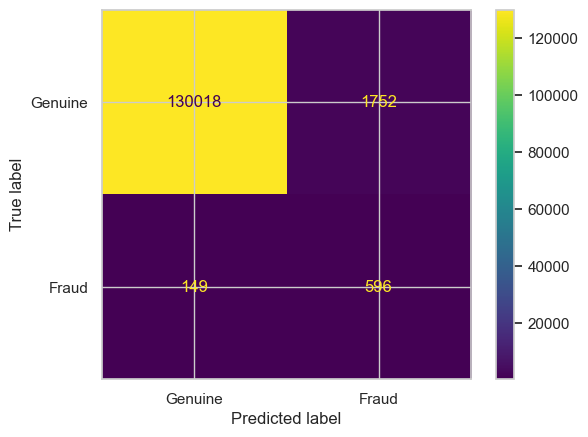

In [23]:
Y_pred_ada = model_ada.predict(X_val)

print(f"Classification Report: \n{classification_report(Y_val, Y_pred_ada)}\n")

print(
    f"Metrics train:\n\tAccuracy score: {accuracy_score(model_ada.predict(X_train),Y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(model_ada.predict(X_val),Y_val):.4f}\n\n")

print("Confusion Matrix:")
cm_display_ada = ConfusionMatrixDisplay(confusion_matrix(Y_val, Y_pred_ada), display_labels=["Genuine", "Fraud"])
cm_display_ada.plot()

### Model: XGBoostClassifier
In order to speedup the algorithm, we use XGBoost.

Create an objective function for Optuna which optimizes for f1 score.

In [12]:
def objective_xgb(trial):
    params = {
        # Determines how far down a decision tree goes before stopping
        "max_depth": trial.suggest_int("max_depth", 3, 25),
        # Determines minimum weight needed for a child
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 7),
        # Determines minimum loss reduction for a split
        "gamma": trial.suggest_float("gamma", 0.05, 1),
        # Determines the learning rate
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 1),
        # Determines fraction of features used per tree
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1),
        "random_state": RANDOM_STATE
        }
    
    model = XGBClassifier(**params)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_val)
    f1 = f1_score(Y_val, Y_pred, average='weighted')

    return 1 - f1 #Since we are minimizing, we want 1-f1

Fitting the data to the XGBClassifier with the hyperparameters found.

In [13]:
study_xgb = optuna.create_study(study_name="study_xgb", direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=20, n_jobs=5)

best_trial_xgb = study_xgb.best_trial
best_params_xgb = best_trial_xgb.params
print(f"Params for XGBoost: {best_params_xgb}")

model_xgb = XGBClassifier(**best_params_xgb)
model_xgb.fit(X_train, Y_train)

[I 2024-01-10 16:05:54,879] A new study created in memory with name: study_xgb
[I 2024-01-10 16:06:04,327] Trial 4 finished with value: 0.003907506546432793 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'gamma': 0.1948525217322014, 'learning_rate': 0.7507621230812019, 'colsample_bytree': 0.9468694130718867}. Best is trial 4 with value: 0.003907506546432793.
[I 2024-01-10 16:06:10,840] Trial 3 finished with value: 0.00258069835368524 and parameters: {'max_depth': 8, 'min_child_weight': 5, 'gamma': 0.8572785400902787, 'learning_rate': 0.8841666145317241, 'colsample_bytree': 0.6962931796551314}. Best is trial 3 with value: 0.00258069835368524.
[I 2024-01-10 16:06:14,912] Trial 1 finished with value: 0.0026854752262068793 and parameters: {'max_depth': 7, 'min_child_weight': 5, 'gamma': 0.6238483597886698, 'learning_rate': 0.9242736945727446, 'colsample_bytree': 0.6669419619116775}. Best is trial 3 with value: 0.00258069835368524.
[I 2024-01-10 16:06:17,884] Trial 0 finished with 

Params for XGBoost: {'max_depth': 18, 'min_child_weight': 7, 'gamma': 0.993236517590738, 'learning_rate': 0.10916241045530184, 'colsample_bytree': 0.7644460804879699}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7644460804879699, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.993236517590738,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.10916241045530184,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=18, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    131770
           1       0.82      0.83      0.83       745

    accuracy                           1.00    132515
   macro avg       0.91      0.92      0.91    132515
weighted avg       1.00      1.00      1.00    132515


Metrics train:
	Accuracy score: 0.9986
Metrics test:
	Accuracy score: 0.9980


Confusion Matrix:


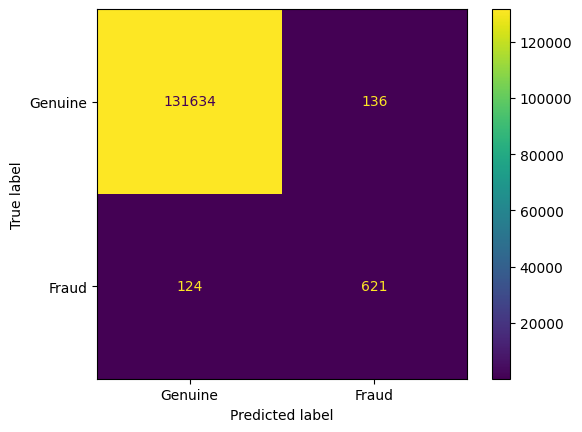

In [14]:
Y_pred_xgb = model_xgb.predict(X_val)

print(f"Classification Report: \n{classification_report(Y_val, Y_pred_xgb)}\n")

print(
    f"Metrics train:\n\tAccuracy score: {accuracy_score(model_xgb.predict(X_train),Y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(model_xgb.predict(X_val),Y_val):.4f}\n\n")

print("Confusion Matrix:")
cm_display_xgb = ConfusionMatrixDisplay(confusion_matrix(Y_val, Y_pred_xgb), display_labels=["Genuine", "Fraud"])
cm_display_xgb.plot()

## Cross Validation

We perform cross validation by comparing `f1` scores across the three models we trained.

In [ ]:
models = {"AdaBoost": model_ada,
          "XGBoost": model_xgb}

strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

best_model = None
best_f1 = None
for name, model in models.items():
    cross_val_res = cross_val_score(model, X_train, Y_train, cv=strat_kf, scoring="f1")

    val_f1 = f1_score(Y_val, model.predict(X_val))

    print(f"{name}: Mean F1 Training = {cross_val_res.mean():.4f}")
    print(f"{name}: F1 Validation = {val_f1:.4f}")

    if best_f1 is None or best_f1 < val_f1:
        best_model = model
        best_f1 = val_f1

```{note}
This may take a while, so not running the cross validation and using the default best model given below should work.
```

We found the best model to be the XGBoosted trees because it has the highest `f1` score.

## Feature Importance: XGBoost and SHAP

We plot the feature importance using XGBoost's built-in feature importance to calculate the relative importances.

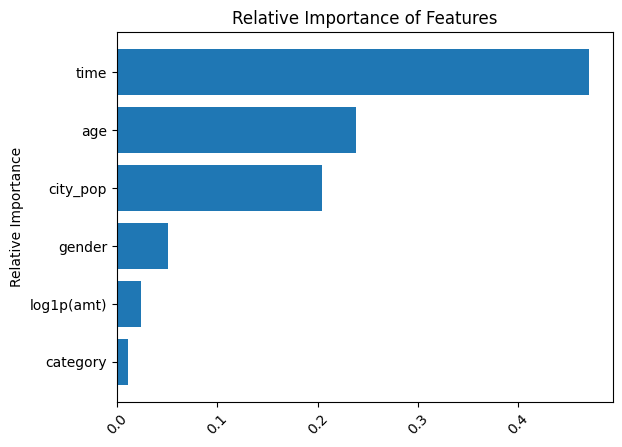

In [16]:
importance_scores = model_xgb.feature_importances_
relative_importance = importance_scores / importance_scores.sum()
relative_importance.sort()

# Plotting
plt.barh(X_train.columns, relative_importance)
plt.xticks(rotation=45)
plt.ylabel('Relative Importance')
plt.title('Relative Importance of Features')
plt.show()

We then compare it to the SHAP values.

[16:08:03] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[16:08:04] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


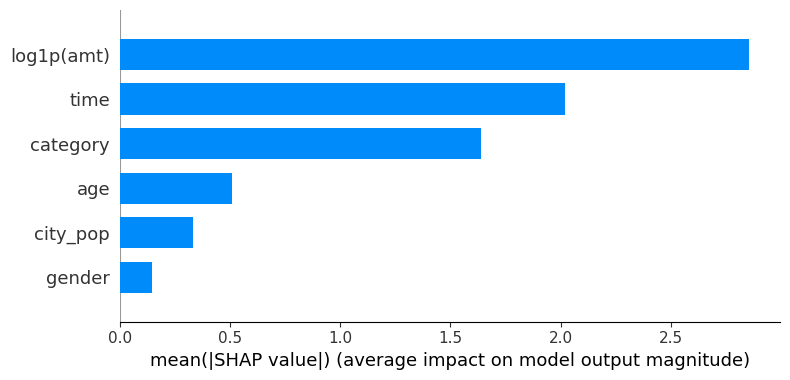

In [17]:
# Convert the data appropriately
data_shap = pd.concat([X_val, Y_val], axis=1)
data_shap_1 = data_shap[data_shap["is_fraud"] == 1].head(50)[selected_features]
data_shap_0 = data_shap[data_shap["is_fraud"] == 0].head(50)[selected_features]
data_shap_reduced = pd.concat([data_shap_0, data_shap_1])

# Explain the model's predictions using SHAP values
explainer = shap.Explainer(model_xgb)
shap_values = explainer(data_shap_reduced)

# Summary Plot
shap.summary_plot(shap_values, data_shap_reduced, feature_names=X_test.columns, plot_type='bar')
plt.show()

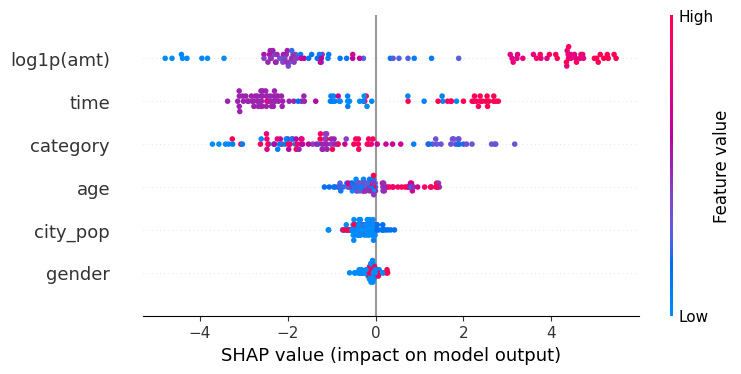

In [18]:
shap.plots.beeswarm(shap_values)

We see that the feature `gender` does not have a large impact on the model output. Therefore, we will excluse it from the data to see if there are improvements to the scores.

In [19]:
new_selected_features = ["category", "log1p(amt)", "gender", "city_pop", "age", "time"]

X_train, X_val, X_test = X_train[new_selected_features], X_val[new_selected_features], X_test[new_selected_features]

model_xgb.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7644460804879699, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.993236517590738,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.10916241045530184,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=18, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    131770
           1       0.82      0.83      0.83       745

    accuracy                           1.00    132515
   macro avg       0.91      0.92      0.91    132515
weighted avg       1.00      1.00      1.00    132515


Metrics train:
	Accuracy score: 0.9986
Metrics test:
	Accuracy score: 0.9980


Confusion Matrix:


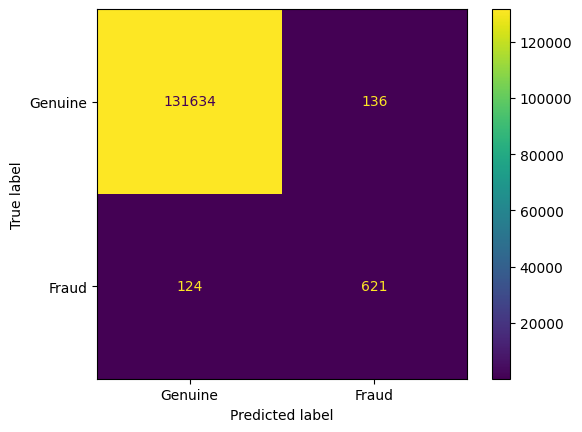

In [20]:
Y_pred_xgb = model_xgb.predict(X_val)

print(f"Classification Report: \n{classification_report(Y_val, Y_pred_xgb)}\n")

print(
    f"Metrics train:\n\tAccuracy score: {accuracy_score(model_xgb.predict(X_train),Y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(model_xgb.predict(X_val),Y_val):.4f}\n\n")

print("Confusion Matrix:")
cm_display_xgb = ConfusionMatrixDisplay(confusion_matrix(Y_val, Y_pred_xgb), display_labels=["Genuine", "Fraud"])
cm_display_xgb.plot()

We did not see any differences in accuracy and f1 score when including the `gender` feature and not. Thus, for simplicity and performance, we will not include `gender` in our final data for our model.

## Testing

Finally, we perform a final test on the best model.

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    149533
           1       0.82      0.85      0.84       948

    accuracy                           1.00    150481
   macro avg       0.91      0.93      0.92    150481
weighted avg       1.00      1.00      1.00    150481


Metrics test:
	Accuracy score: 0.9979


Confusion Matrix:


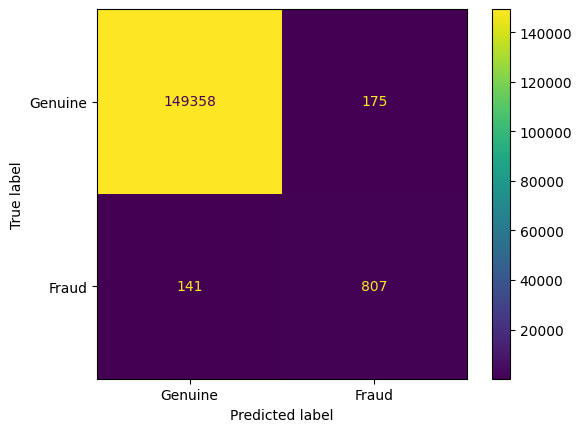

In [21]:
try:
    Y_pred_best = best_model.predict(X_test)
except (NameError, AttributeError):
    best_model = model_xgb
    Y_pred_best = best_model.predict(X_test)

print(f"Classification Report: \n{classification_report(Y_test, Y_pred_best)}\n")

print(
    f"Metrics test:\n\tAccuracy score: {accuracy_score(best_model.predict(X_test),Y_test):.4f}\n\n")

print("Confusion Matrix:")
cm_display_best = ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_pred_best), display_labels=["Genuine", "Fraud"])
cm_display_best.plot()

## Summary

Since we are doing fraud detection, we would want to prioritize precision because marking non-fraudulent transactions as frauds can have large  legal repercussions, and even lead to criminal offenses and large fines.

The baseline performance had a very high accuracy score on the training set, which could show signs of overfitting.

Overall, XGBoost had a better accuracy, precision, recall and f1 score compared to AdaBoost. It also had much better performance in speed compared to both Random Forest and AdaBoost, thus making it the best choice in classifying fraudulent transactions.

Using SHAP, we found that our initial feature seleciton could be improved by removing the `gender` feature.